In [173]:
import sacc
import numpy as np
import pyccl as ccl
import rosatX as rx
import pyatomdb
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

In [174]:
rmf = fits.open('data/pspcb_gain2_256.rmf')
arf = fits.open('data/pspcb_gain2_256.arf')
cls_cov = sacc.Sacc.load_fits('data/cls_cov_Y3iv_marg_dz_m.fits')

ROSAT, DESY3wl__3, cov = cls_cov.get_ell_cl('cl_0e','ROSAT', 'DESY3wl__3', return_cov=True)
err = np.sqrt(np.diagonal(cov))

with open('data/J_tot', "rb") as f:
    J = pickle.load(f)

In [175]:
COSMO_P18 = {"Omega_c": 0.26066676,
             "Omega_b": 0.048974682,
             "h": 0.6766,
             "n_s": 0.9665,
             "sigma8": 0.8102,
             "matter_power_spectrum": "linear"}

cosmo = ccl.Cosmology(**COSMO_P18)
mdef = ccl.halos.MassDef200c
cM = ccl.halos.ConcentrationDuffy08(mass_def=mdef)

dmat = ccl.halos.HaloProfileNFW(mass_def=mdef, concentration=cM)

nM = ccl.halos.MassFuncTinker08(mass_def=mdef)
bM = ccl.halos.HaloBiasTinker10(mass_def=mdef)
hmc = ccl.halos.HMCalculator(mass_function=nM,
                             halo_bias=bM,
                             mass_def=mdef,
                             log10M_max=15., log10M_min=10, nM=32)

# X-ray tracer
tx = rx.XrayTracer(cosmo)

zs = cls_cov.tracers['DESY3wl__3'].z
nz = cls_cov.tracers['DESY3wl__3'].nz

# gamma tracer
ts = ccl.WeakLensingTracer(cosmo, dndz=(zs, nz))


def pixel_FWHM(nside):
    """
    Returns the FWHM of the HEALPix pixel with nside = nside
    """
    fwhm_hp_amin =  60 * 41.7 / nside
    return np.radians(fwhm_hp_amin/60)/2.355

sigma_ROSAT = np.radians(1.8e0/60)/2.355
sigma_HEALPix = pixel_FWHM(1024)

sigma_tot_2 = sigma_ROSAT**2 + 2*sigma_HEALPix**2

def cl_smoothing_factor(ell):
    return np.exp(-0.5*sigma_tot_2*ell*(1+ell))

In [176]:
prof_dens = rx.HaloProfileDensityHE(mass_def=mdef,
                                    concentration=cM,
                                    kind='n_total')
prof_pres = rx.HaloProfilePressureHE(mass_def=mdef,
                                     concentration=cM,
                                     kind='n_total')

prof_xray = rx.HaloProfileXray(mass_def=mdef, J=J,
                               dens=prof_dens,
                               pres=prof_pres,
                               fourier_approx=False,
                               with_clumping=True)

In [177]:
k_arr = np.geomspace(1e-4,1e2,256)
a_arr = np.linspace(0.3,1,8)

ls = np.unique(np.geomspace(2, 3100, 128).astype(int)).astype(float)

pkx = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat,
                             prof2=prof_xray,
                             lk_arr=np.log(k_arr), a_arr=a_arr)

cls = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pkx)

cls *= cl_smoothing_factor(ls)

In [178]:
def update_params(params, pvec):
    
    pdict = {'lMc': 14.0,
             'alpha_T': 1.0,
             'eta_b': 0.5,
             'gamma': 1.17,
             'logTAGN': None}
    
    for k, v in zip([params], [pvec]):
        pdict[k] = v
    
    kwargs = {k: pdict.get(k, None)
    for k in ['lMc', 'alpha_T', 'eta_b',
              'gamma', 'logTAGN']}
    prof_dens.update_parameters(**kwargs)
    prof_pres.update_parameters(**kwargs)
    
    new_prof = rx.HaloProfileXray(mass_def=mdef, J=J,
                                   dens=prof_dens,
                                   pres=prof_pres,
                                   fourier_approx=False,
                                   with_clumping=True)
    return new_prof

def get_cls(params, pvec):
    
    cls_mat = np.zeros((len(pvec), len(ls)))
    
    for i in range(len(pvec)):
        prof = update_params(params, pvec[i])

        pk = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat,
                                     prof2=prof,
                                     lk_arr=np.log(k_arr),
                                     a_arr=a_arr)

        cl = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk)
        cl *= cl_smoothing_factor(ls)

        cls_mat[i] = cl

    return cls_mat

In [179]:
clx_gamma = get_cls('gamma', np.linspace(1.1, 1.5, 5))

clx_lMc = get_cls('lMc', np.linspace(13.0, 15.0, 5))

clx_alphaT = get_cls('alpha_T', np.linspace(0.5, 2.0, 5))

clx_eta_b = get_cls('eta_b', np.linspace(0.2, 2.0, 5))

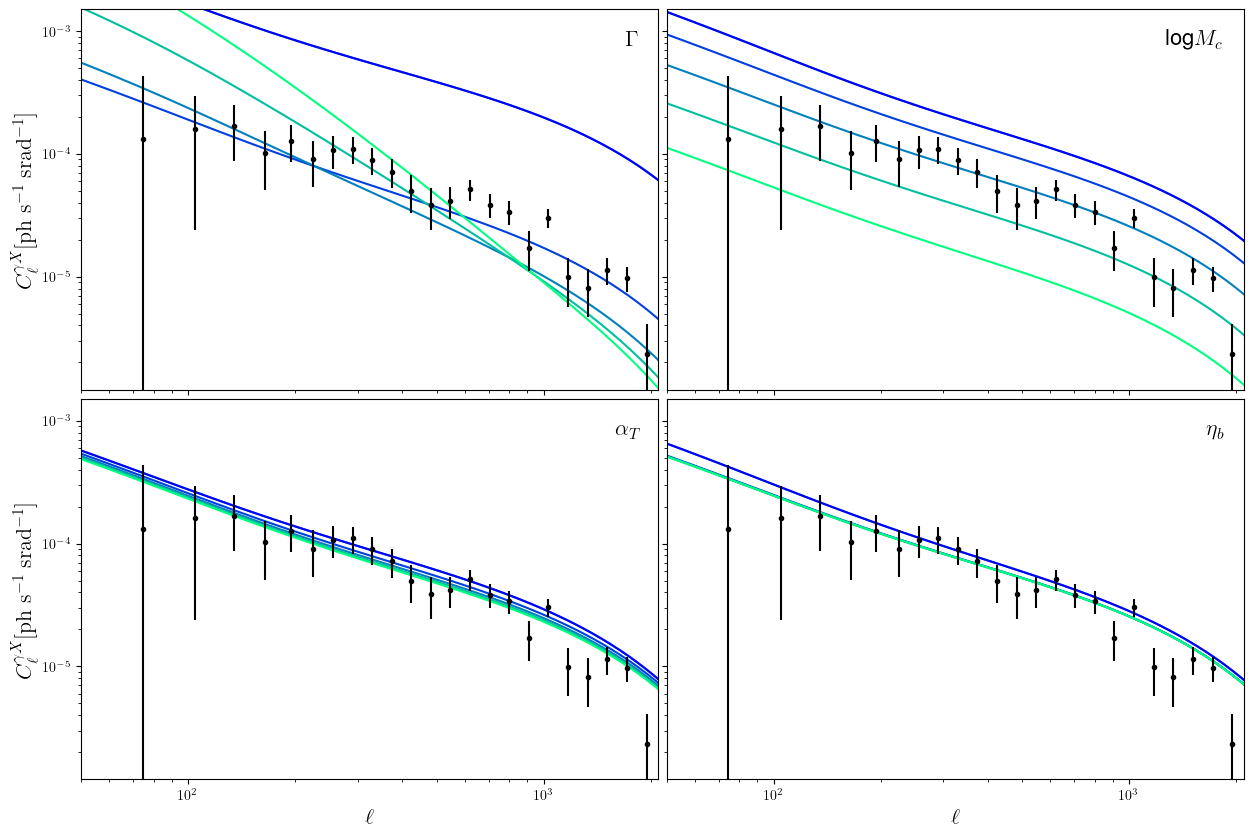

In [180]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    
ax[0,0].plot(ls, clx_gamma[0], label=r'$\Gamma$')
for i in range(5):
    ax[0,0].plot(ls, clx_gamma[i], c=color[i])
ax[0,0].errorbar(ROSAT, DESY3wl__3, yerr=err, fmt='k.')
ax[0,0].set_ylabel(r'$C_\ell^{\gamma X} \mathrm{[ph\ s^{-1}\ srad^{-1}]}$', fontsize=16)
ax[0,0].tick_params(labelbottom=False)

ax[0,1].plot(ls, clx_lMc[0], label=r'log$M_c$')
for i in range(5):
    ax[0,1].plot(ls, clx_lMc[i], c=color[i])
ax[0,1].errorbar(ROSAT, DESY3wl__3, yerr=err, fmt='k.')
ax[0,1].tick_params(labelbottom=False,
                    labelleft=False)

ax[1,0].plot(ls, clx_alphaT[0], label=r'$\alpha_T$')
for i in range(5):
    ax[1,0].plot(ls, clx_alphaT[i], c=color[i])
ax[1,0].errorbar(ROSAT, DESY3wl__3, yerr=err, fmt='k.')
ax[1,0].set_xlabel(r'$\ell$', fontsize=16)
ax[1,0].set_ylabel(r'$C_\ell^{\gamma X} \mathrm{[ph\ s^{-1}\ srad^{-1}]}$', fontsize=16)

ax[1,1].plot(ls, clx_eta_b[0], label=r'$\eta_b$')
for i in range(5):
    ax[1,1].plot(ls, clx_eta_b[i], c=color[i])
ax[1,1].errorbar(ROSAT, DESY3wl__3, yerr=err, fmt='k.')
ax[1,1].set_xlabel(r'$\ell$', fontsize=16)
ax[1,1].tick_params(labelleft=False)

for j in range(2):
    for i in range(2):
        ax[i,j].loglog()
        ax[i,j].legend(handlelength=0, handletextpad=0, frameon=False, fontsize=16)
        ax[i,j].set_ylim([1.2e-6, 1.5e-3])
        ax[i,j].set_xlim([50, 2100])
        
plt.subplots_adjust(wspace=0.015, hspace=0.025)

fig.savefig('Plots/Cls_params.pdf')